# Horizontal convergence of vertically-integrated heat fluxes

In [1]:
# Import packages
import numpy as np
import xarray as xr
import xgcm
from matplotlib import pyplot as plt

import sectionate as sec
import regionate as reg

# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")

# Set figure font size
plt.rcParams.update({'font.size':12})

from plotting_routines import *

## 1. Load data

In [2]:
from load_example_model_grid import load_MOM6_zint_heat_budget
grid = load_MOM6_zint_heat_budget()
ds = grid._ds

# Thermdynamic constants used in Boussinesq heat budget
rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K

File 'MOM6_global_example_vertically_integrated_heat_budget_v0_0_6.nc' already exists at ../data/MOM6_global_example_vertically_integrated_heat_budget_v0_0_6.nc. Skipping download.


## 2. Explanatory analysis of the heat budget terms

#### Plot the vertically integrated heat budget

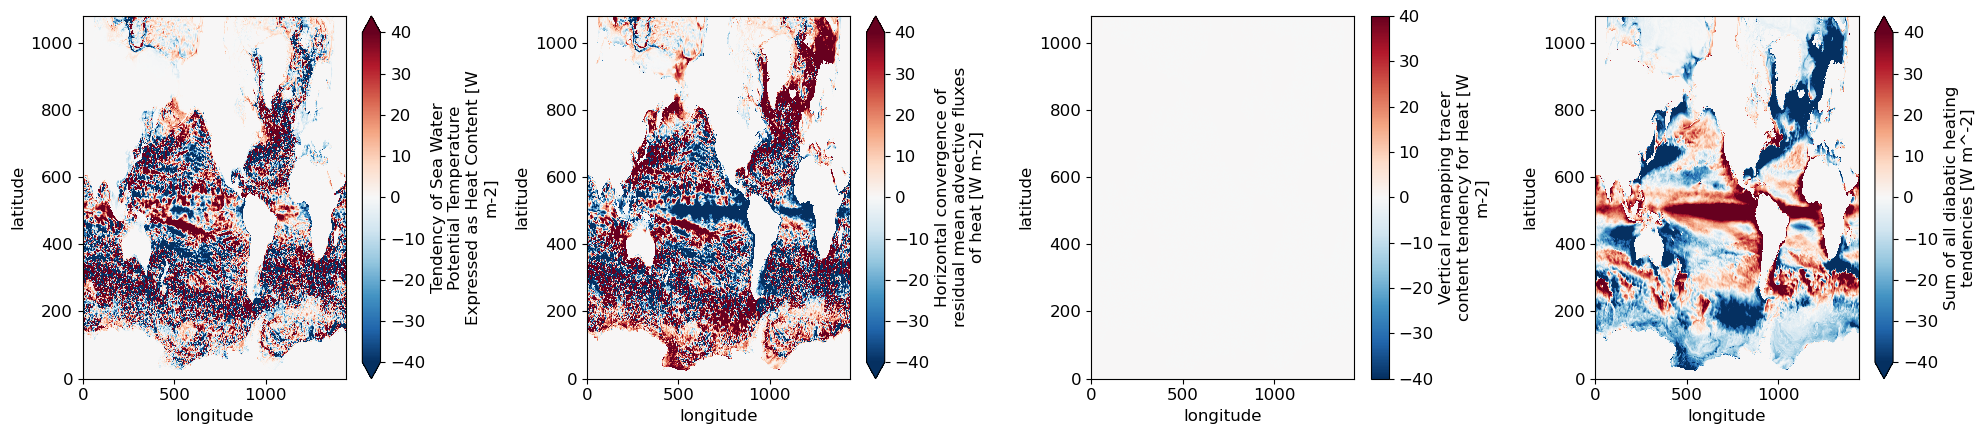

In [3]:
fig, axes = plt.subplots(1,4, figsize=(20, 4.5))
ds['opottemptend'].plot(ax=axes[0], vmin=-40, vmax=40, cmap="RdBu_r")
ds['T_advection_xy'].plot(ax=axes[1], vmin=-40, vmax=40, cmap="RdBu_r")
ds['Th_tendency_vert_remap'].plot(ax=axes[2], vmin=-40, vmax=40, cmap="RdBu_r")
ds['diabatic_forcing'] = (ds['boundary_forcing_heat_tendency']+
 ds['internal_heat_heat_tendency']+
 ds['frazil_heat_tendency']+
 ds['opottempdiff']
)
ds['diabatic_forcing'].attrs = {'long_name': "Sum of all diabatic heating tendencies", 'units': "W m^-2"}
ds['diabatic_forcing'].plot(ax=axes[3], vmin=-40, vmax=40, cmap="RdBu_r")
for ax in axes:
    ax.set_title("")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
plt.tight_layout()

## 3. Regional heat budgets

We would live to investigate the heat budget in a sub-region of this domain, including both a volume-integral perspective within the volume and–thanks to the divergence theorem–a surface integral view that corresponds to the convergent fluxes along the boundary of the region.

While the volume-integrals of the tendency terms (on the tracer grid) are straight-forward to evaluate using a Boolean mask on the same grid, finding the correct indices (and signs) for the corrsponding boundary-normal fluxes is much more challenging.

### Verifying the divergence theorem for area integrals over complicated sub-domains

The extensive heat (or, equivalently, potential temperature) equation in MOM6 is given by
\begin{equation}
C_{p}\rho_{0}\left[\partial_{t} (\Theta h) + \nabla_{r} \cdot (\mathbf{u} \Theta h) + \delta_{r}(\Theta z_{r} \dot{r}) = J_{\Theta}\right].
\end{equation}

Integrating in $z$ and over a region $(x,y)\in \mathcal{R}$ (like the sub-domain defined above), the heat budget is
\begin{equation}
\partial_{t} H = \iint_{\mathcal{R}} - \nabla \cdot \mathbf{\mathcal{H}} \, \text{d}A + C_{p}\rho_{0}J_{\Theta}. \quad\quad\text{where }\mathbf{\mathcal{H}} \equiv C_{p}\rho_{0}\int \mathbf{u} \Theta h \,\text{d}z\quad\text{ is the vertically-integrated heat flux.}
\end{equation}

Applying the divergence theorem, we can rewrite
\begin{equation}
\iint_{\mathcal{R}} -\nabla \cdot \mathbf{\mathcal{H}} \, \text{d}A = \int_{\partial \mathcal{R}}  \mathbf{\mathcal{H}} \cdot \mathbf{n}_{in} \,\text{d}l \equiv \Psi_{\Theta}, 
\end{equation}
with $\Psi_{\Theta}$ the horizontally convergent heat transport. We evaluate the LHS area integral by applying a mask to the diagnosed dynamical heat tendency term and the RHS boundary integral term by accumulating normal heat fluxes (with positive velocities defined inwards) along the region's boundary.

The normal-flux perspective is useful because it allows you to attribute volume-integrated changes within a region to particular inflows and outflows along the boundary.

### 3.0. **Default approach**: using index slices to select a box that approximates ther region of interest

While we include this manual-indexing approach for completeness, we do not recommend it as the indexing (and sign-correcting) process for accumulating bounary fluxes is tedious and prone to indexing errors, especially when switching between different model grid geometries or generalizing to non-rectangular regions.

In [4]:
def coord_to_index(coord, dim):
    if dim=="X":
        return np.int64(np.round(np.abs(ds.geolon - coord).argmin("xh").median()))
    elif dim=="Y":
        return np.int64(np.round(np.abs(ds.geolat - coord).argmin("yh").median()))

x_slice = slice(coord_to_index(13., "X"), coord_to_index(26., "X"))
y_slice = slice(coord_to_index(53.5, "Y"), coord_to_index(63., "Y"))

We have not been able to reconcile boundary-normal fluxes with the volume integral.


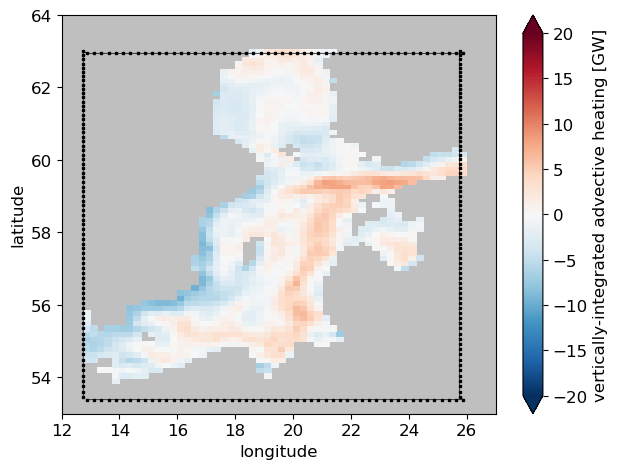

In [5]:
advective_heating = (ds['T_advection_xy']*ds['areacello']).sel(
    xh=x_slice,
    yh=y_slice
).squeeze()

convergent_heat_transport_manual = xr.concat(
    [
        +xr.DataArray(# Southern boundary
            ds['T_ady'].sel(yq=y_slice.start, method="nearest").sel(xh=x_slice)
            .swap_dims({"xh":"sect"}).rename({"xh":"x", "yq":"y", "geolon_v":"geolon_uv", "geolat_v":"geolat_uv"}).drop(["dxCv", "wet_v"])
        ),
        -xr.DataArray(# Eastern boundary
            ds['T_adx'].sel(xq=x_slice.stop, method="nearest").sel(yh=y_slice)
            .swap_dims({"yh":"sect"}).rename({"xq":"x", "yh":"y", "geolon_u":"geolon_uv", "geolat_u":"geolat_uv"}).drop(["dyCu", "wet_u"])
        ),
        -xr.DataArray(# Northern boundary
            ds['T_ady'].sel(yq=y_slice.stop, method="nearest").sel(xh=slice(x_slice.stop, x_slice.start, -1))
            .swap_dims({"xh":"sect"}).rename({"xh":"x", "yq":"y", "geolon_v":"geolon_uv", "geolat_v":"geolat_uv"}).drop(["dxCv", "wet_v"])
        ),
        +xr.DataArray(# Western boundary
            ds['T_adx'].sel(xq=x_slice.start, method="nearest").sel(yh=slice(y_slice.stop, y_slice.start, -1))
            .swap_dims({"yh":"sect"}).rename({"xq":"x", "yh":"y", "geolon_u":"geolon_uv", "geolat_u":"geolat_uv"}).drop(["dyCu", "wet_u"])
        )
    ],
    dim="sect", coords="minimal"
)

plt.subplot(facecolor=(0.75, 0.75, 0.75))
plt.pcolor(
    grid._ds.geolon.sel(xh=x_slice, yh=y_slice),
    grid._ds.geolat.sel(xh=x_slice, yh=y_slice),
    advective_heating.where(advective_heating!=0)*1e-9,
    cmap="RdBu_r",
    vmin=-20,
    vmax=20,
)
plt.colorbar(label="vertically-integrated advective heating [GW]", extend="both")
plt.plot(convergent_heat_transport_manual.geolon_uv, convergent_heat_transport_manual.geolat_uv, "ks-", markersize=2, lw=0.5)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()
plt.xlim(12, 27)
plt.ylim(53, 64)

if np.isclose(advective_heating.sum().values, convergent_heat_transport_manual.sum("sect").values, rtol=1.e-5):
    print(
    """
    We have verified that the convergent heat flux across the region's boundary
    is equal (within float32 precision) to the volume integral within the region.
    """
    )
else:
    print("We have not been able to reconcile boundary-normal fluxes with the volume integral.")

While trying to manually find the indices required to close the control volume, we were off by a single index -- notice how the black boundary does not line up with the mask on the northern and eastern boundaries. The result is that our heat budget does not close.

### 3.1. **Using `regionate`**, we replicate the above results but with a much more user-friendly API and generalizable algorithm

Rather than manually indexing for both the mask and the boundary transports (which are on staggered grids), we just provide the vertices of the rectangular polygon we are interested in.

In [6]:
lons = np.array([13.,   26., 26., 13.])
lats = np.array([53.5, 53.5, 63., 63.])
region = reg.GriddedRegion("Baltic", lons, lats, grid)


    We have verified that the convergent heat flux across the region's boundary
    is equal (within float32 precision) to the volume integral within the region.
    


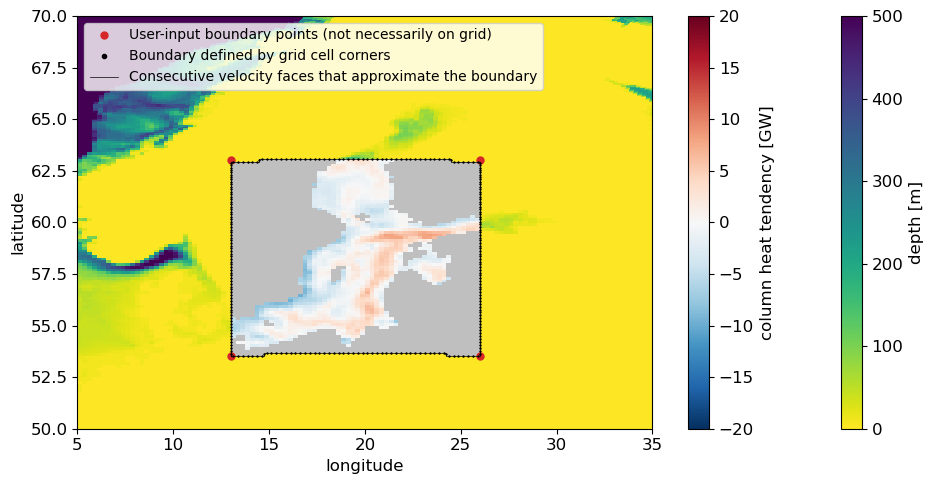

In [7]:
dheatdt_dynamics = (ds['T_advection_xy']*ds['areacello']).squeeze()
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.)

# From volume integral of horizontal advective tendencies
advective_heating = dheatdt_dynamics.where(region.mask).sum(['xh', 'yh']).squeeze().values # LHS

# From normal-surface integral of diagnosed horizontal heat fluxes
convergent_heat_transport = sec.convergent_transport(
    grid,
    region.i_c,
    region.j_c,
    utr="T_adx",
    vtr="T_ady",
    layer="z_l",
    interface="z_i",
    outname="conv_heat_transport"
)['conv_heat_transport'].sum(["z_l", "sect"]).compute()

plt.figure(figsize=(10, 5))
plt.subplot(facecolor=(0.75, 0.75, 0.75))
pc = geoplot(
    ds,
    dheatdt_dynamics.where(region.mask)*1e-9,
    alpha=1.0, cmap="RdBu_r", vmin=-2e1, vmax=2e1
)
depth_cmap = plt.get_cmap("viridis_r").copy()
pc_dep = geoplot(ds, ds.deptho.where(~region.mask), cmap=depth_cmap, vmin=0, vmax=500)
plt.plot(lons, lats, "C3o", markersize=5, label="User-input boundary points (not necessarily on grid)")
plt.plot([],[],"k.",label="Boundary defined by grid cell corners")
plt.plot(reg.loop(region.lons_c), reg.loop(region.lats_c), "k-", linewidth=0.5, label="Consecutive velocity faces that approximate the boundary")
plt.plot(region.lons_uv, region.lats_uv, "k+", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column heat tendency [GW]")
plt.legend(loc = "upper left", fontsize=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()

if np.isclose(advective_heating.sum(), convergent_heat_transport.values, rtol=1.e-4):
    print(
    """
    We have verified that the convergent heat flux across the region's boundary
    is equal (within float32 precision) to the volume integral within the region.
    """
    )
else:
    print("We have no been able to reconcile boundary-normal fluxes with the volume integral.")

plt.xlim(5, 35)
plt.ylim(50, 70);

By contrast, `regionate` automatically finds the correct boundaries.

### 3.2. **Generalizing to any closed polygonal region, leveraging `sectionate`'s ability to find grid-conforming shortest paths**

In [8]:
name = "Baltic"
lons = np.array([13, 10, 9.0, 10., 12, 20.,  29., 24.5, 23.5, 22.5, 17.5])
lats = np.array([58, 57.5, 56, 54, 53.5, 53.5, 54.5,  59.,  61.,  63., 64.5])
region = reg.GriddedRegion(name, lons, lats, grid)

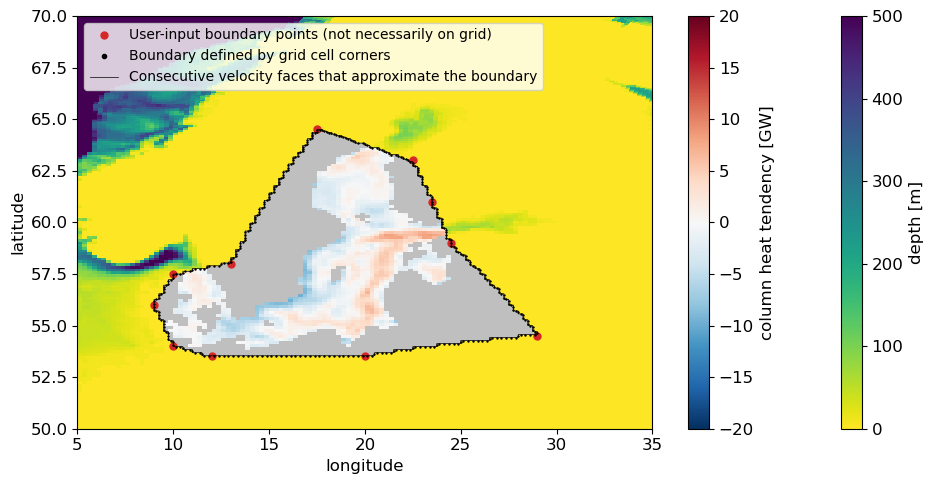

In [9]:
dheatdt_dynamics = (ds['T_advection_xy']*ds['areacello']).sum('z_l').squeeze()
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(facecolor=(0.75, 0.75, 0.75))
pc = geoplot(
    ds,
    dheatdt_dynamics.where(region.mask)*1e-9,
    alpha=1.0, cmap="RdBu_r", vmin=-2e1, vmax=2e1
)
pc_dep = geoplot(ds, ds.deptho.where(~region.mask), cmap="viridis_r", vmin=0, vmax=500)
plt.plot(lons, lats, "C3o", markersize=5, label="User-input boundary points (not necessarily on grid)")
plt.plot([],[],"k.",label="Boundary defined by grid cell corners")
plt.plot(reg.loop(region.lons_c), reg.loop(region.lats_c), "k-", linewidth=0.5, label="Consecutive velocity faces that approximate the boundary")
plt.plot(region.lons_uv, region.lats_uv, "k+", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column heat tendency [GW]")
plt.legend(loc = "upper left", fontsize=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()

plt.xlim(5, 35)
plt.ylim(50, 70);


In [10]:
# From volume integral of horizontal advective tendencies
advective_heating = dheatdt_dynamics.where(region.mask).sum(['xh', 'yh']).squeeze().values # LHS

# From normal-surface integral of diagnosed horizontal heat fluxes
convergent_heat_transport = sec.convergent_transport(
    grid,
    region.i_c,
    region.j_c,
    utr="T_adx",
    vtr="T_ady",
    layer="z_l",
    interface="z_i",
    outname="conv_heat_transport"
)['conv_heat_transport']

cumulative_convergent_heat_transport = (
    convergent_heat_transport
    .cumsum("sect").sel(z_l=ds.z_l[::-1])
    .cumsum('z_l').sel(z_l=ds.z_l[::-1])
).compute()

net_convergent_heat_transport = cumulative_convergent_heat_transport.isel(sect=-1, z_l=-1).values

rtol = 1.e-5
print(f"Verify divergence theorem: {np.isclose(net_convergent_heat_transport, advective_heating, rtol=1.e-4, atol=0.)}")

Verify divergence theorem: [ True]


We can almost close the budget to single-precision floating point (float32) precision, which is the best we can hope for given the precision of our diagnostics.

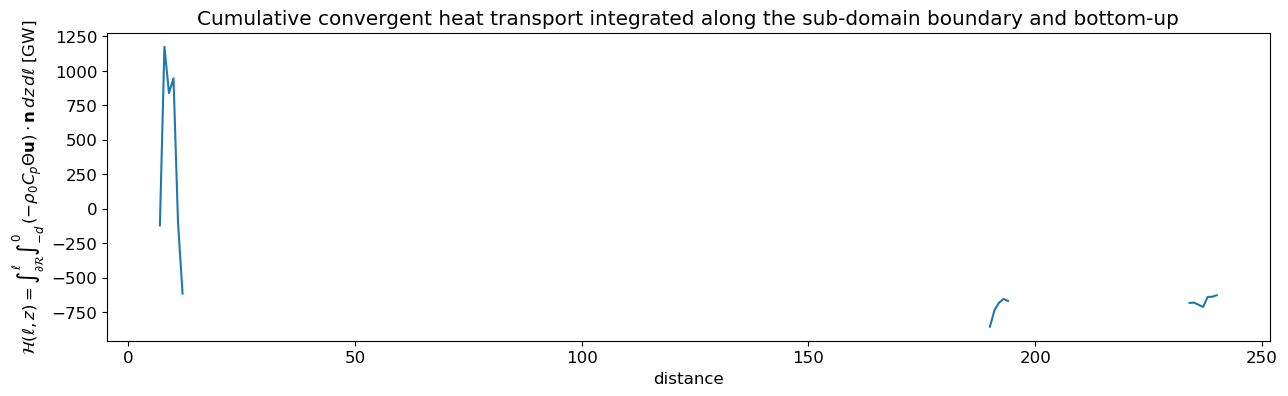

In [11]:
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad((0.75, 0.75, 0.75))
plt.figure(figsize=(15, 4))
da_plot = (
    (cumulative_convergent_heat_transport*1e-9)
    .where(convergent_heat_transport!=0.)
    .swap_dims({'sect':'distance'})
)
pc = da_plot.plot(x="distance")
plt.title("Cumulative convergent heat transport integrated along the sub-domain boundary and bottom-up")
plt.ylabel(r"$\mathcal{H}(\ell, z) = \int_{\partial \mathcal{R}}^{\ell} \int_{-d}^{0} \, (- \rho_{0} C_{p} \Theta \mathbf{u})  \cdot \mathbf{n} \,dz\,d\ell$ [GW]");

<div class="alert alert-block alert-danger">
    <b>Warning!</b>
    <p>Estimating normal heat fluxes by calculating the product of time-averaged diagnostics of temperature (or heat content) and volume transports is frought with errors, since it omits any temporal correlations (i.e. eddy fluxes) below the averaging period. For annual- or monthly-averaged output in an eddying model, these errors are often $\mathcal{O}(1)$!</p>
</div>
    


### 3.3. Using a gridded mask to define regions (and their normal boundaries) 

Suppose we want to understand the heat budget of shallow shelves in the Baltic Sea region. Specifying the polygon(s) that define these complicated coastal regions would be tedious, so we would like to instead be able to use a gridded Boolean mask area instead.

In [12]:
mask = ds['deptho'].fillna(0.) < 30

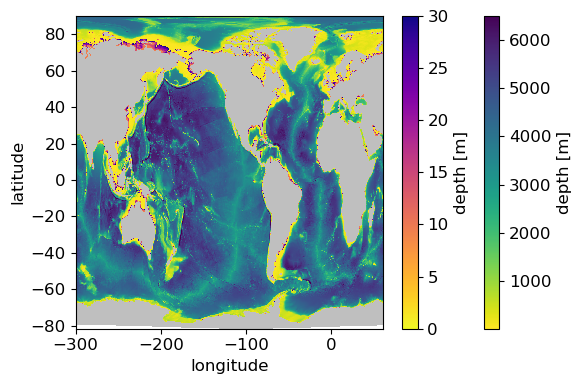

In [13]:
plt.figure(figsize=(6, 4))
depth_cmap.set_bad((0.75, 0.75, 0.75))
pc = geoplot(
    ds,
    ds['deptho'].where(ds['deptho']!=0.),
    cmap=depth_cmap
)
mask = ds['deptho'].fillna(0.) < 30
cf = geoplot(
    ds,
    ds['deptho'].where(
        np.logical_and(
            ds['deptho'].fillna(0.)!=0,
            mask
        )
    ),
    alpha=1,
    cmap="plasma_r",
    vmin=0,
    vmax=30
)
plt.colorbar(pc, label="depth [m]")
plt.colorbar(cf, label="depth [m]")
plt.xlabel("longitude")
plt.ylabel("latitude");
plt.tight_layout()

`regionate` leverages `contourpy` (the backend algorithm behind `matplotlib`'s contour plots) to generate a dictionary of distinct polygonal boundaries that define the mask.

In [14]:
regions = reg.MaskRegions(mask, grid)
print(f"The mask's boundary is made up of {len(regions.region_dict)} distinct polygonal regions.")

The mask's boundary is made up of 672 distinct polygonal regions.


But this isn't quite what we wanted, because this map is for all global shallow shelf regions, whereas we want to focus on just the shallow parts of the Greater Baltic Sea!

### 3.4. Specifying complicated regions by combining polygons with gridded masks

Here, we demonstrate how seemingly very complicated masks (and boundaries) can be generated by combining the polygonal masks with gridded masks. For example, suppose we are interested in the heat budget of shallow regions within the interior Baltic Sea region, i.e. the intersection of the interior Baltic-sea mask from 3.2 and the mask of all regions shallower than 30 meters from 3.3.

In [15]:
polygon_mask = reg.GriddedRegion("Baltic sea", lons, lats, grid).mask
gridded_mask = ds['deptho'].fillna(0.) < 30
mask = polygon_mask & gridded_mask

In [16]:
regions = reg.MaskRegions(mask, grid)
print(f"The mask's boundary is made up of {len(regions.region_dict)} distinct polygonal regions.")

The mask's boundary is made up of 10 distinct polygonal regions.


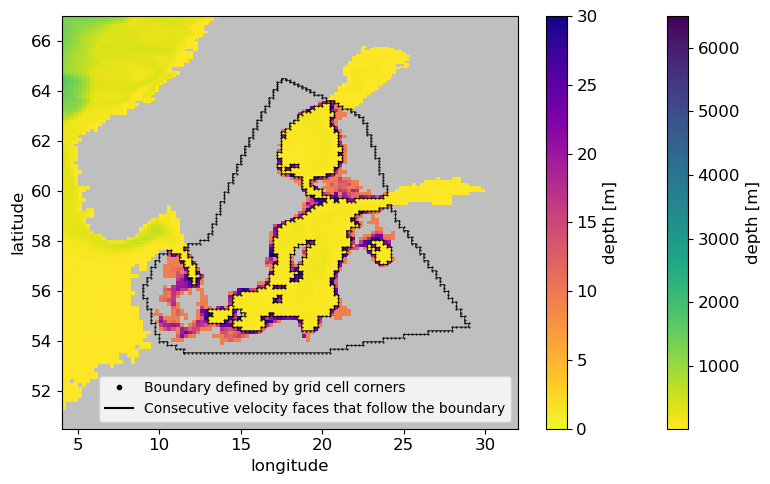

In [17]:
plt.figure(figsize=(8, 5))
pc = geoplot(
    ds,
    ds['deptho'].where(ds['deptho']!=0.),
    cmap=depth_cmap
)
mask = regions.mask
cf = geoplot(
    ds,
    ds['deptho'].where(
        np.logical_and(
            ds['deptho'].fillna(0.)!=0,
            mask
        )
    ),
    alpha=1,
    cmap="plasma_r",
    vmin=0,
    vmax=30
)
plt.colorbar(pc, label="depth [m]")
plt.colorbar(cf, label="depth [m]")

for region in regions.region_dict.values():
    plt.plot(reg.loop(region.lons_c), reg.loop(region.lats_c), "k.-", markersize=1, lw=0.5)
plt.plot([],[],"k.",label="Boundary defined by grid cell corners")
plt.plot([],[],"k-",label="Consecutive velocity faces that follow the boundary")
plt.ylim(50.5, 67)
plt.xlim(4, 32)
plt.xlabel("longitude")
plt.ylabel("latitude");
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()

In [18]:
total_convergent_heat_transport = 0.

for p, region in enumerate(regions.region_dict.values()):
    net_convergent_heat_transport = sec.convergent_transport(
        grid,
        region.i_c,
        region.j_c,
        utr="T_adx",
        vtr="T_ady",
        layer="z_l",
        interface="z_i",
        outname="conv_heat_transport",
        positive_in=regions.mask
    )['conv_heat_transport'].sum(["sect", "z_l"]).compute().values
    
    total_convergent_heat_transport += net_convergent_heat_transport
    
advective_heating = dheatdt_dynamics.where(regions.mask).sum(["xh", "yh"]).values

rtol = 1e-3
print(f"Verify divergence theorem within rtol={rtol}: {np.isclose(total_convergent_heat_transport, advective_heating, rtol=rtol, atol=0)}")

Verify divergence theorem within rtol=0.001: [ True]
